In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
from collections import defaultdict
import csv
from scipy.io import loadmat
from scipy.signal import find_peaks
import pandas as pd

In [15]:
## import ttl trains
ttl_path = '/vol/cortex/cd1/Data/lyndsay/Behavior/M136/20241016/M136-20241016-153545-TTL.h5'
def load_ttl_file(ttl_path):
    ttl_streams = defaultdict(list)
    with h5py.File(ttl_path, 'r') as file:
        k = file.keys()
        device_name = list(k)[0]
        dataset = file[device_name]
        for key in dataset.keys():
            ttl_streams[key] = np.array(dataset[key])
    return ttl_streams

ttl_streams = load_ttl_file(ttl_path)

In [23]:
nidaq_sampling_rate = 20000  # in hz
twop_sampling_rate = 30      # in hz
camera_sampling_rate = 200   # in hz

## 2p ttl

### smooth ttl train

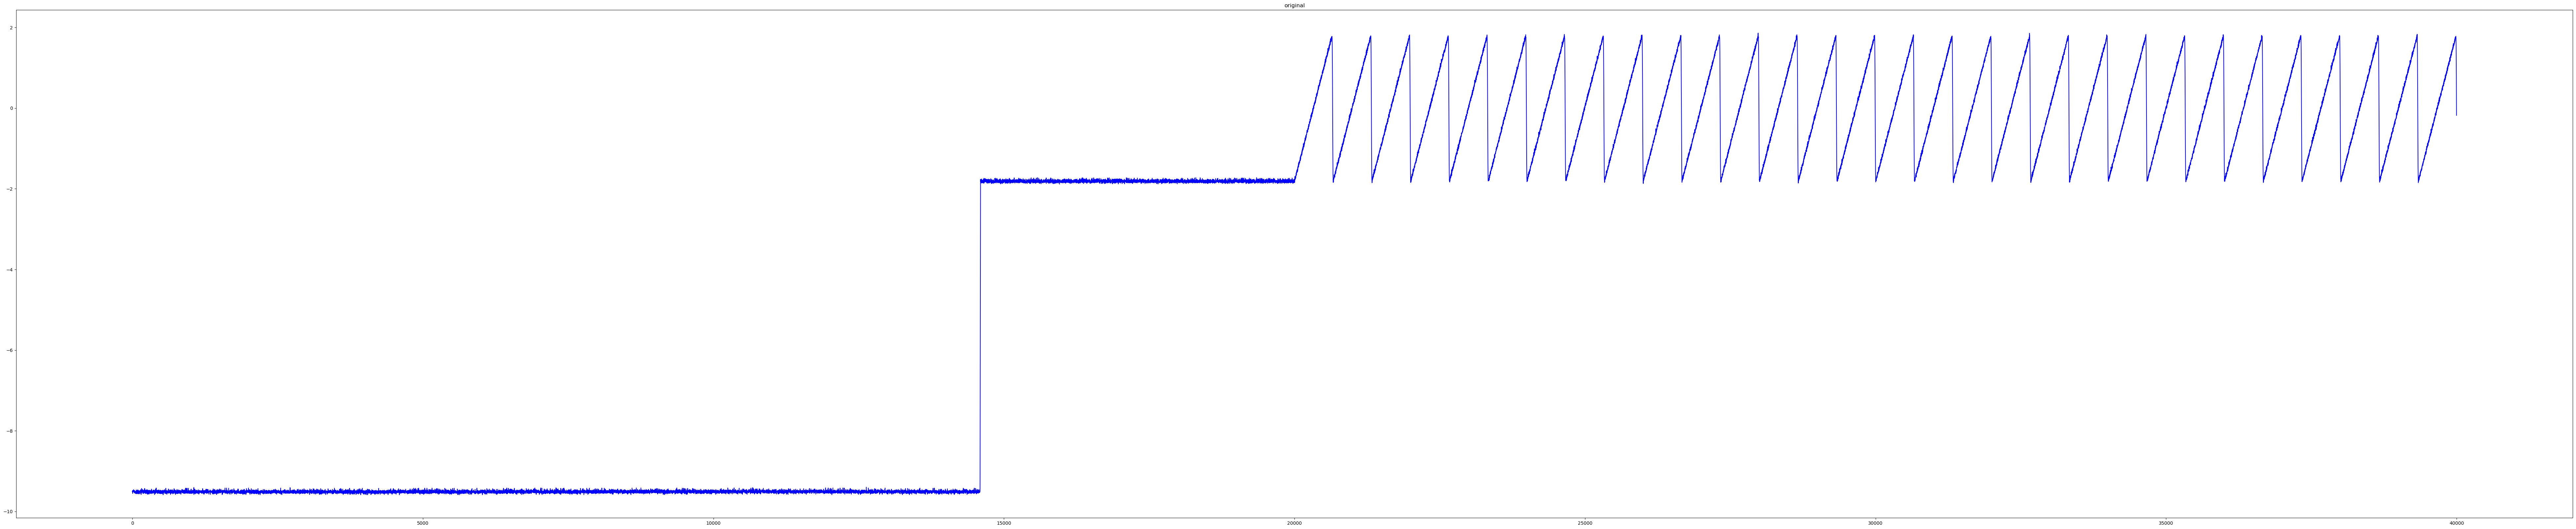

In [18]:
# plot original trace
plt.figure(figsize=(100,20))
plt.plot(ttl_streams['ai5'][1016251-20000:1016251+20000], color='b')
plt.title('original')
plt.show()

In [4]:
inverse = -ttl_streams['ai5']  # flip ttl trace so that start of frames are maxs instead of mins
inverse_smoothed = np.convolve(inverse, np.ones(5)/5, mode='valid')  # smooth by convolving 

### find all peaks except first

In [5]:
peaks = find_peaks(inverse_smoothed, prominence=2, distance=600)[0]  # find peaks in smoothed inverse
y = np.full(len(peaks), 2)

/home/lyndsay/miniconda3/envs/analysis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


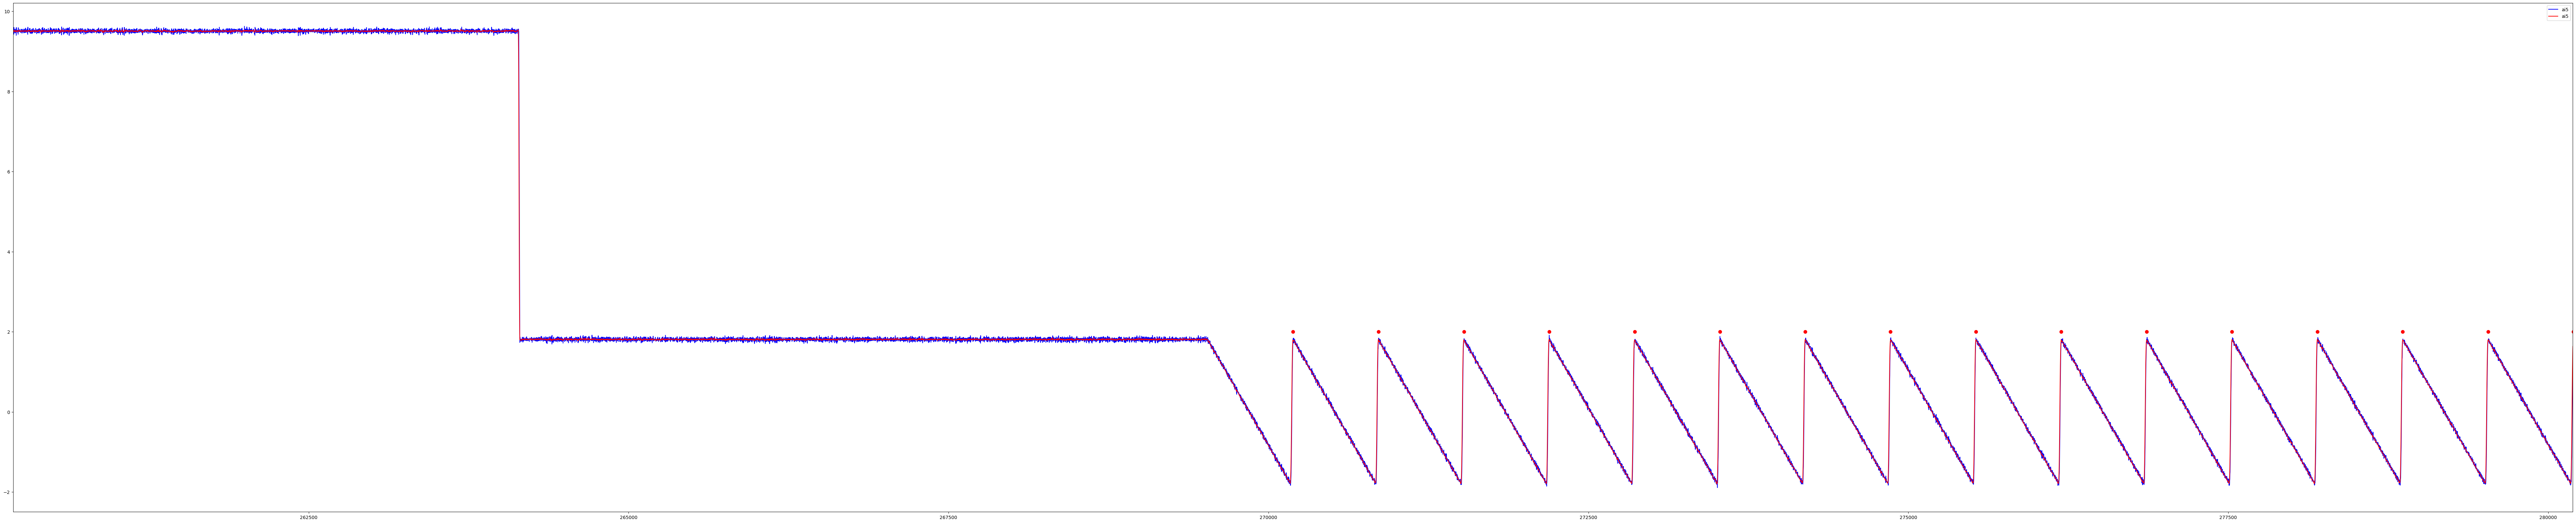

In [17]:
plt.figure(figsize=(100,20))
plt.plot(inverse, label = "ai5", color = 'b')
plt.plot(inverse_smoothed, label = "ai5", color = 'r')
plt.scatter(peaks, y, s = 50, color='r')
plt.xlim(peaks[0]-10000, peaks[0]+10000)
plt.legend()
plt.show()

### find first peak based on slope

slope:  269530


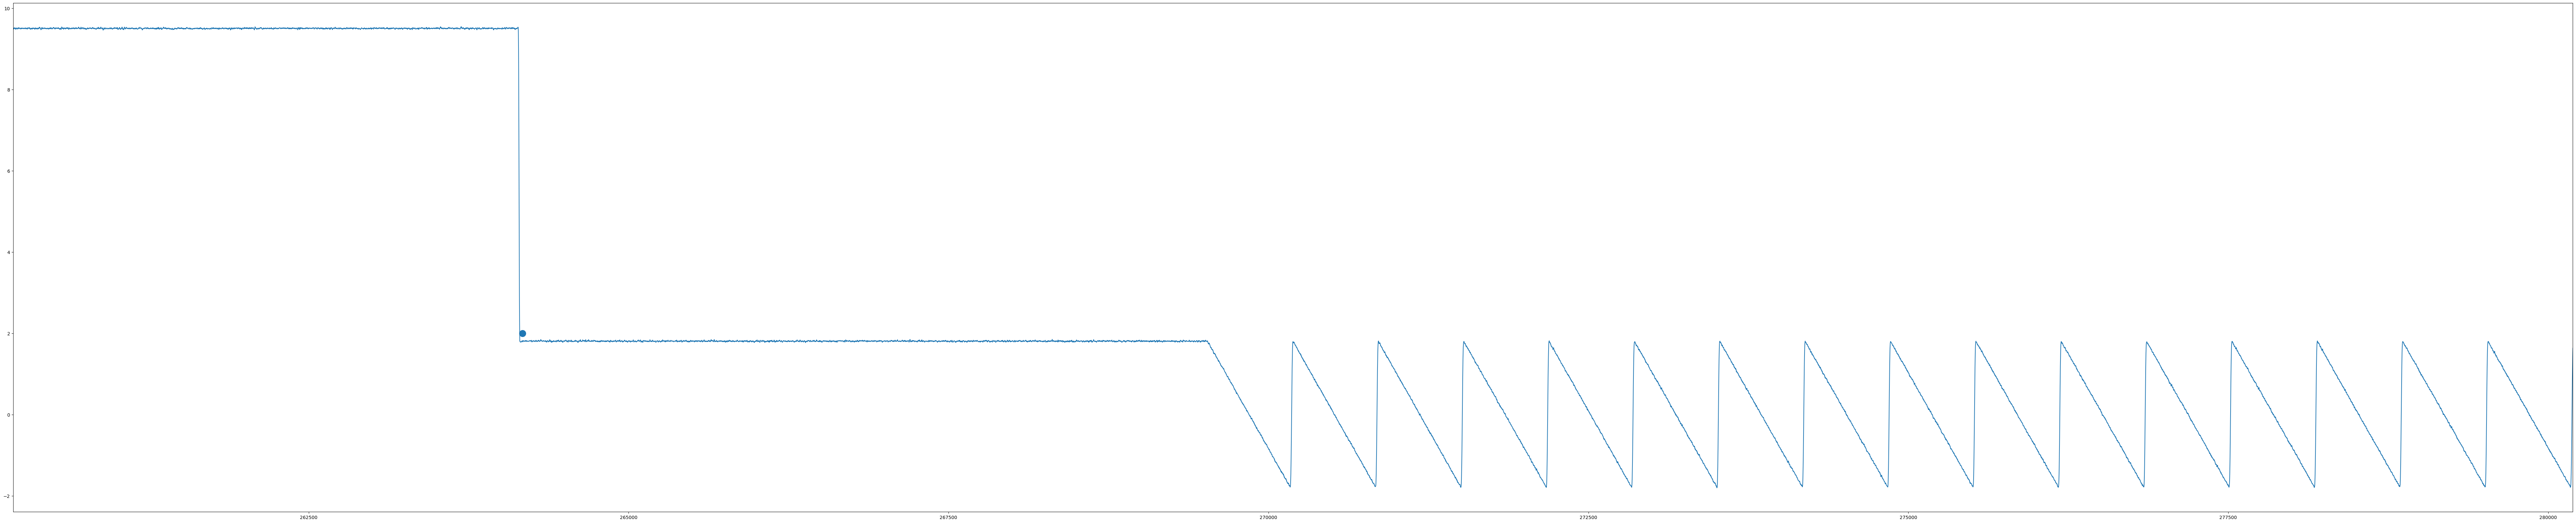

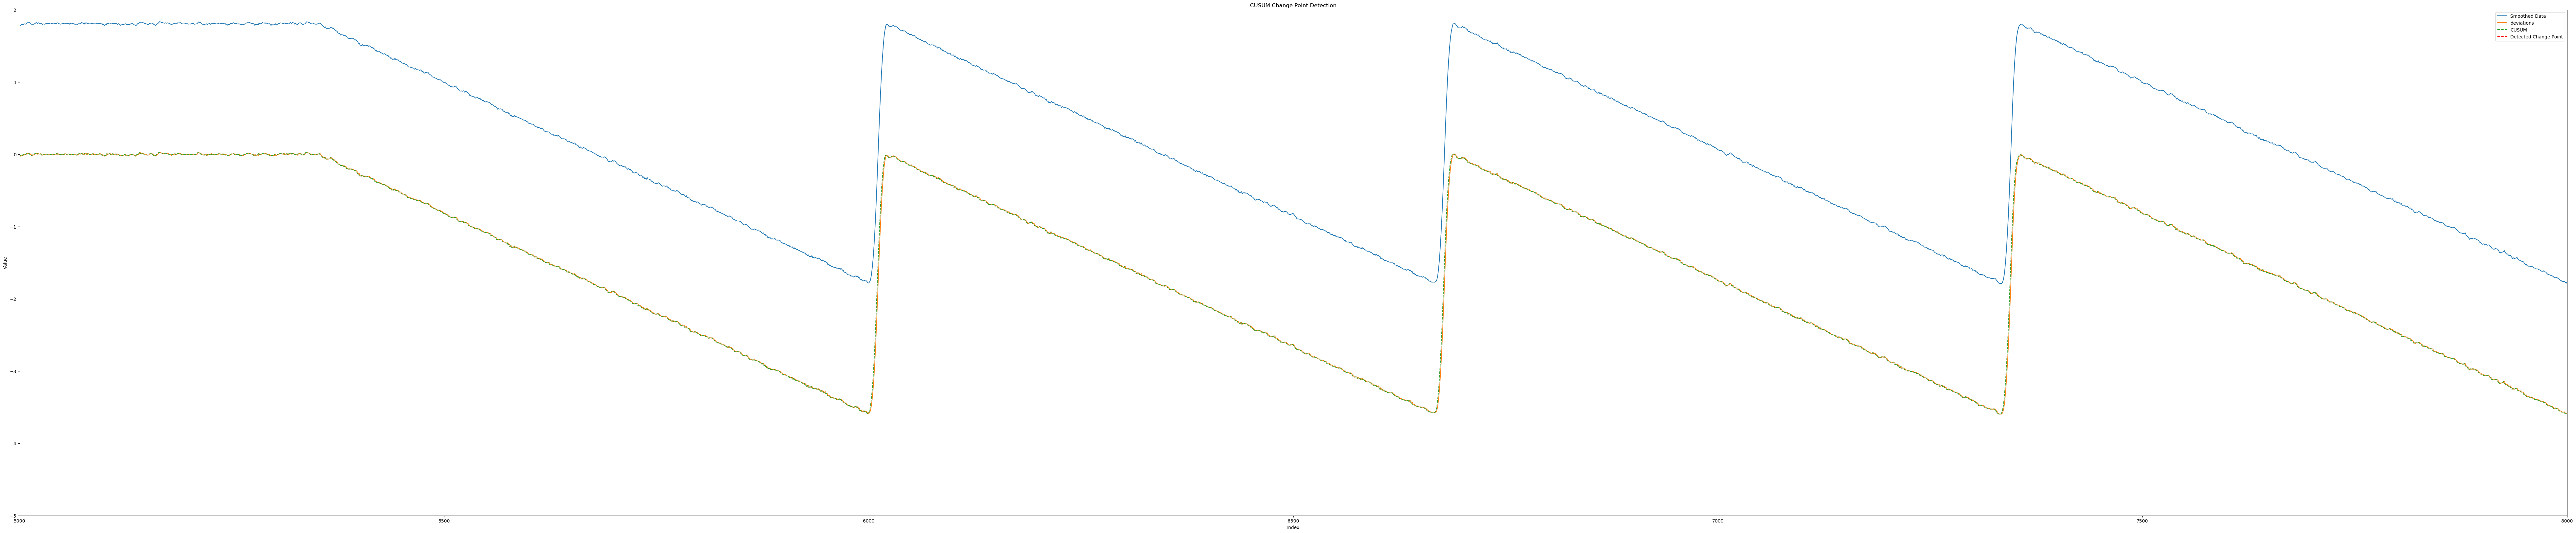

In [9]:
inverse = -ttl_streams['ai5']  # flip ttl trace so that start of frames are maxs instead of mins
inverse_smoothed = np.convolve(inverse, np.ones(5)/5, mode='valid')  # smooth by convolving 
data = inverse_smoothed  # don't use all data to speed up

data_diffs = np.diff(data)  
plateau_thresh = 0.5
plateau_end = np.argmax(np.abs(data_diffs) > plateau_thresh)+30   # find when 1st plateau ends using difference between adjacent data points

post_plateau_data = data[plateau_end:]   # subset the data

mean_level = np.mean(post_plateau_data[:4000])  # estimate baseline mean from initial flat region
deviations = post_plateau_data - mean_level   # calculate deviations from this mean

cusum = np.cumsum(deviations)  # calculate cumulative sum of deviations
cusum_diffs = np.diff(cusum)  # use difference in cumulative sum because of noise in data

threshold = -0.05  # threshold for downward slope
sustained_points = 2  # number of consecutive points required

below_threshold = cusum_diffs < threshold  # where do cusum_diffs meet threshold 

for i in range(len(below_threshold) - sustained_points + 1):   # check where threshold meeting is sustained
    if np.all(below_threshold[i:i + sustained_points]):
        start_slope = i
        break
else:
    start_slope = None

start_slope = start_slope+plateau_end

print('slope: ', start_slope)

# original data with plateau end marked
plt.figure(figsize=(100,20))
plt.plot(data)
plt.scatter(plateau_end, 2, s=200)
plt.xlim(peaks[0]-10000, peaks[0]+10000)
plt.plot()

# data, deviations, cusum_diffs, and change point
plt.figure(figsize=(100,20))
plt.plot(post_plateau_data, label="Smoothed Data")
plt.plot(deviations, label="deviations")
plt.plot(cusum_diffs, label="CUSUM", linestyle="--")
plt.axvline(start_slope, color="red", linestyle="--", label="Detected Change Point")
plt.legend()
plt.ylim(-5, 2)
plt.xlim(5000, 8000)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("CUSUM Change Point Detection")
plt.show()

In [18]:
peaks_full = np.insert(peaks, 0, start_slope)  # insert first peak at beginning of peak array

In [19]:
# check if there is an extra peak at the end from end of plateau, remove if necessary
print(peaks_full[-5:])
peaks_diffs = np.diff(peaks_full[-20:])

if peaks_diffs[-1] > 700:
    peaks_full = peaks_full[:-1]
    print('removed', peaks_full[-5:])
else:
    print('nothing removed', peaks_full[-5:])

[24280477 24281145 24281812 24282481 24604701]
removed [24279811 24280477 24281145 24281812 24282481]


In [88]:
# save out frame lists
twop_frames = peaks_full
np.savetxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/frames/twop_frames.txt', twop_frames, delimiter=',')

twop_frames_downsample4 = peaks_full[::4]
np.savetxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/frames/twop_frames_downsample4.txt', twop_frames_downsample4, delimiter=',')

## camera ttl

In [75]:
#sidecam_smoothed = np.convolve(ttl_streams['ai1'], np.ones(5)/5, mode='valid')  # smooth by convolving
sidecam_diffs = np.diff(ttl_streams['ai1'])  

In [85]:
sidecam_diffs[sidecam_diffs < 0] = 0  # cut neg values to not lose peaks in ttl drop
sidecam_double_diffs = np.diff(sidecam_diffs)   # find slope of point to point differences
sidecam_peaks = find_peaks(sidecam_double_diffs, prominence=0.5, distance=90)[0]  # find peaks in smoothed inverse
y = np.full(len(sidecam_peaks)-1, 0)

In [86]:
sidecam_peaks = sidecam_peaks[:-1]

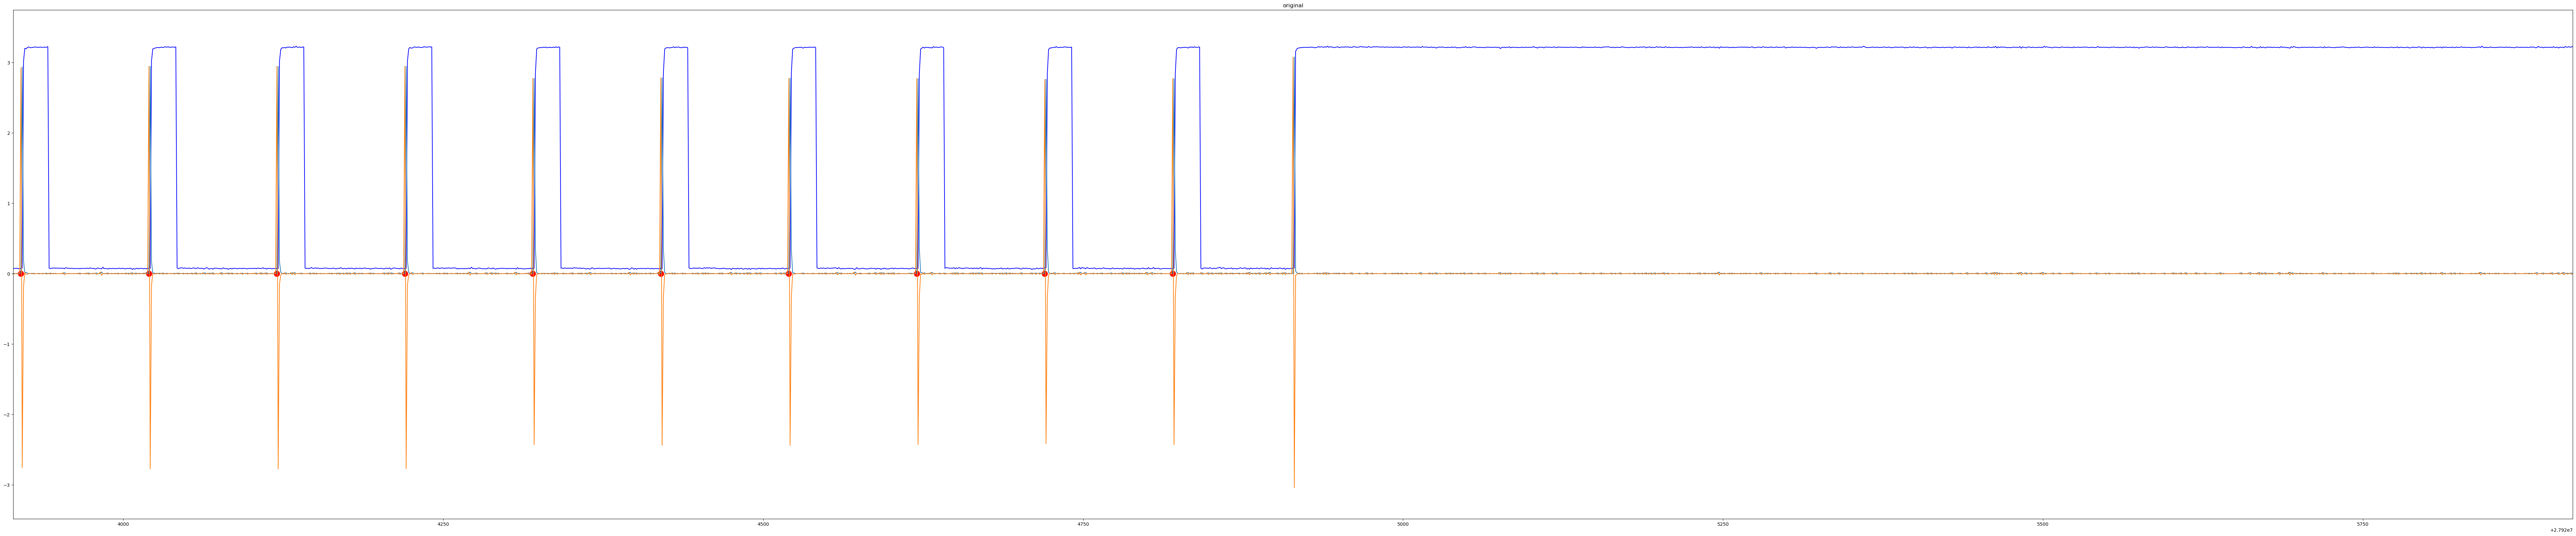

In [87]:
# plot original trace
plt.figure(figsize=(100,20))
plt.plot(ttl_streams['ai1'], color='b')
plt.plot(sidecam_diffs)
plt.plot(sidecam_double_diffs)
plt.scatter(sidecam_peaks, y, color='r', s=150)
plt.title('original')
plt.xlim(27924914-1000,27924914+1000)

plt.show()

In [89]:
# save out frame lists
sidecam_frames = sidecam_peaks
np.savetxt('/vol/cortex/cd1/Analysis/lyndsay/M136/2024-10-16/full/frames/sidecam_frames.txt', sidecam_frames, delimiter=',')